# Tensor

In [ ]:
import torch
from torchvision.transforms import Normalize, ToPILImage
from utils.plot import plot_pil_images

In [ ]:
x = torch.randn([1,256,256])
x = x.squeeze()
x.shape

torch.Size([256, 256])

In [ ]:
x = torch.randn([3,256,256])
x.shape

torch.Size([3, 256, 256])

In [ ]:
torch.unsqueeze(x, 0).shape

torch.Size([1, 3, 256, 256])

In [ ]:
x.flatten(1,2).shape

torch.Size([3, 65536])

In [ ]:
x.flatten(1,2).mean(axis=1).shape

torch.Size([3])

In [ ]:
x = torch.randn([1,256,256])
x.transpose(0,1).shape

torch.Size([256, 1, 256])

In [ ]:
torch.manual_seed(12)
x = torch.randn([1,3])
x.max(), x.argmax()

(tensor(-0.0546), tensor(2))

## cat vs stack

In [ ]:
assert (torch.Tensor([1,2,3]) == torch.tensor([1,2,3])).all()

In [ ]:
a = torch.Tensor([1])
b = torch.Tensor([2])
torch.cat([a,b], dim=0)

tensor([1., 2.])

In [ ]:
torch.stack([a,b], dim=0)

tensor([[1.],
        [2.]])

In [ ]:
torch.stack([a,b], dim=1)

tensor([[1., 2.]])

# Element size

In [ ]:
a.nelement()

1

In [ ]:
a.element_size()  # in bytes

4

Total memory allocation:


In [ ]:
a.nelement() * a.element_size()

4

# Inverse Normalizer

```
new_x = (x - mean) / std
x = new_x * std + mean
x = (new_x + mean/std) * std
x = (new_x - mean/std) / (1/std)

inv_std = 1/(std + epsilon)
inv_mean = -mean/std = mean*inv_std
```

In [ ]:
class InverseNormalize(Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, normalizer):
        mean = normalizer.mean
        std = normalizer.std
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [ ]:
normalizer = Normalize(mean=torch.Tensor([0.1902, 0.2077, 0.1599]), std=torch.Tensor([0.1060, 0.1060, 0.1071]))

In [ ]:
normalizer.mean

tensor([0.1902, 0.2077, 0.1599])

In [ ]:
inv_normalizer = InverseNormalize(normalizer)

In [ ]:
inv_normalizer

InverseNormalize(mean=tensor([-1.7943, -1.9594, -1.4930]), std=tensor([9.4340, 9.4340, 9.3371]))

In [ ]:
torch.manual_seed(12)
a = torch.randn(3,2,2)
a

tensor([[[-0.2138, -1.3780],
         [-0.0546,  0.4515]],

        [[ 0.7858, -1.0884],
         [-0.5599, -0.9336]],

        [[ 0.0479, -0.0844],
         [-0.1471,  0.7590]]])

In [ ]:
normalizer(a)

tensor([[[ -3.8115, -14.7940],
         [ -2.3096,   2.4655]],

        [[  5.4541, -12.2277],
         [ -7.2413, -10.7672]],

        [[ -1.0455,  -2.2806],
         [ -2.8660,   5.5942]]])

In [ ]:
inv_normalizer(normalizer(a))


tensor([[[-0.2138, -1.3780],
         [-0.0546,  0.4515]],

        [[ 0.7858, -1.0884],
         [-0.5599, -0.9336]],

        [[ 0.0479, -0.0844],
         [-0.1471,  0.7590]]])

In [ ]:
assert (inv_normalizer(normalizer(a)) - a < 10e-7).all()

# Masking via `masked_fill`

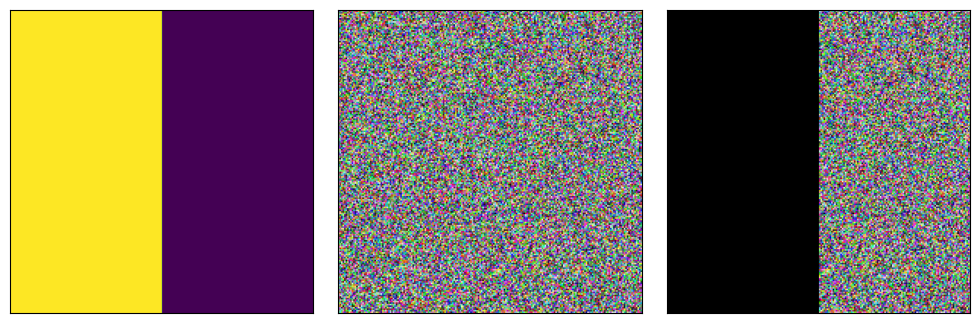

In [ ]:
torch.manual_seed(12)
N = 200
a = torch.rand(3,N,N)
b = torch.cat([torch.ones(N,N//2), torch.zeros(N,N//2)], dim=1).long()
_ = plot_pil_images([ToPILImage()(b.float()), ToPILImage()(a), ToPILImage()(a.masked_fill_(b, 0))])

note that shape of `a` is {{a.shape}} and shape of `b` is {{b.shape}} so `b` was broadcasted in `a.masked_fill_(b, 0)`.

`masked_fill` works similar in 4 dimensions:

torch.Size([2, 300, 300])
torch.Size([2, 3, 300, 300])
torch.Size([2, 1, 300, 300])
torch.Size([2, 3, 300, 300])


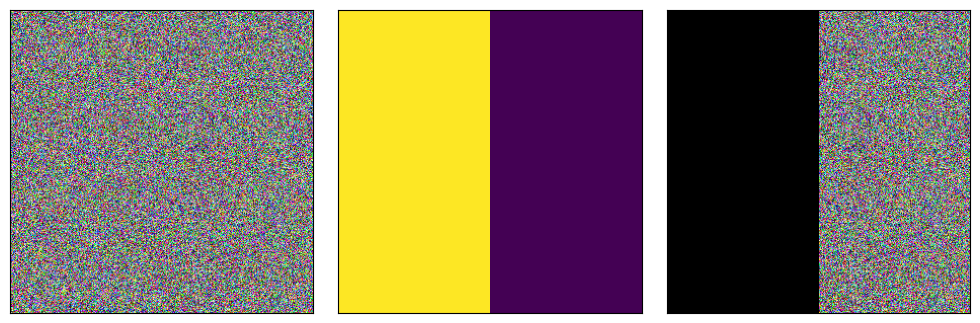

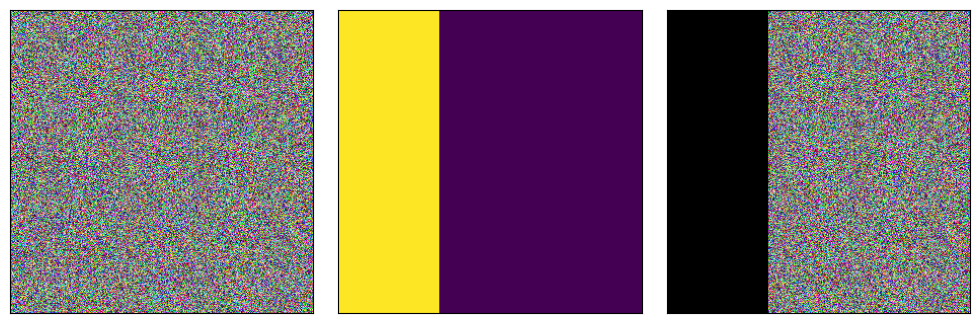

In [ ]:
torch.manual_seed(12)
N = 300
a = torch.rand(2,3,N,N)
b1 = torch.cat([torch.ones(N,N//2), torch.zeros(N,N//2)], dim=1).long()
b2 = torch.cat([torch.ones(N,N//3), torch.zeros(N,2*N//3)], dim=1).long()
b = torch.stack([b1,b2])
print(b.shape)
print(a.shape)
b = b.unsqueeze(axis=1)  # this adds channel dimension = 1 that is needed for masked_fill 
print(b.shape)
c = a.masked_fill(b, 0)
print(c.shape)
for i in range(2):
    _ = plot_pil_images([ToPILImage()(a[i,:,:,:]),
                         ToPILImage()(b[i,:,:,:].float()),
                         ToPILImage()(c[i,:,:,:])])

Note that we had to add `unsqueeze` for `b` to achieve proper broadcasting.

# Masked mean and stdev

**This is rather useless since final normalization results tend to be similar. Keeping it here in case I need it in the future.**

Sometimes we don't want the mean of the whole image but only of the non-zero values. For that we need to find limit the array to non zero values first then find the mean and stdev. Let's do this for one image then extend to 3 channels, and finally for a full batch:

In [ ]:
n_images = 10
n_channels = 3
imgs = torch.randn([n_images, n_channels, 100,100])

Let's first flatten tensor:

In [ ]:
flatten_imgs = imgs.flatten(2,3)
flatten_imgs.shape

torch.Size([10, 3, 10000])

For one image, one channel:

In [ ]:
array = flatten_imgs[0,0,:]

In [ ]:
array = array[array > 0]
array.mean(), array.std()

(tensor(0.7873), tensor(0.6029))

For one image, all three channels:

In [ ]:
array = flatten_imgs[0,:,:]

In [ ]:
means_per_channel = torch.zeros(n_channels)
stdevs_per_channel = torch.zeros(n_channels)
for i in range(n_channels):
    array_per_channel = array[i, :]
    array_per_channel = array_per_channel[array_per_channel>0]
    means_per_channel[i] = array_per_channel.mean()
    stdevs_per_channel[i] = array_per_channel.std()
means_per_channel, stdevs_per_channel

(tensor([0.7873, 0.8032, 0.7925]), tensor([0.6029, 0.5983, 0.5995]))

And now for the whole tensor:

In [ ]:
means_per_image_per_channel = torch.zeros(n_images, n_channels)
stdevs_per_image_per_channel = torch.zeros(n_images, n_channels)
for i in range(n_images):
    for j in range(n_channels):
        array_per_image_per_channel = flatten_imgs[i, j, :]
        array_per_image_per_channel = array_per_image_per_channel[array_per_image_per_channel>0]
        means_per_image_per_channel[i,j] = array_per_image_per_channel.mean()
        stdevs_per_image_per_channel[i,j] = array_per_image_per_channel.std()
means_per_image_per_channel, stdevs_per_image_per_channel

(tensor([[0.7873, 0.8032, 0.7925],
         [0.7860, 0.7971, 0.8038],
         [0.7988, 0.8052, 0.8056],
         [0.7989, 0.8025, 0.7976],
         [0.7914, 0.7798, 0.7897],
         [0.7992, 0.8158, 0.7668],
         [0.8038, 0.7937, 0.7977],
         [0.7868, 0.7956, 0.8038],
         [0.7891, 0.8032, 0.7991],
         [0.7872, 0.8016, 0.8135]]),
 tensor([[0.6029, 0.5983, 0.5995],
         [0.5981, 0.5994, 0.6075],
         [0.6066, 0.6124, 0.6055],
         [0.6031, 0.5922, 0.6137],
         [0.5902, 0.6009, 0.6004],
         [0.6131, 0.6234, 0.5902],
         [0.6138, 0.6055, 0.6082],
         [0.5974, 0.5982, 0.6019],
         [0.6044, 0.6084, 0.6079],
         [0.5932, 0.6091, 0.6187]]))